loading data

In [58]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scipy
import os
import os.path as osp
import pickle
from sklearn.metrics import adjusted_rand_score
 

In [59]:
# for loading DLPFC12 data
def load_DLPFC(root_dir='/Users/zhuyuling/Desktop/Dataset/DLPFC12', section_id='151507'):
    # 151507, ..., 151676 
    # 12 in total, 7 layers
    # 151507: n_obs × n_vars = 4221 × 33538
    ad = sc.read_visium(path=os.path.join(root_dir, section_id), count_file=section_id+'_filtered_feature_bc_matrix.h5')
    ad.var_names_make_unique()

    gt_dir = os.path.join(root_dir, section_id, 'gt')
    gt_df = pd.read_csv(os.path.join(gt_dir, 'tissue_positions_list_GTs.txt'), sep=',', header=None, index_col=0)
    ad.obs['original_clusters'] = gt_df.loc[:, 6]
    keep_bcs = ad.obs.dropna().index
    ad = ad[keep_bcs].copy()
    ad.obs['original_clusters'] = ad.obs['original_clusters'].astype(int).astype(str)
    print("spot num", ad)
    return ad

# for loading mHypothalamus data
# already preprocessed? Xs are floats
def load_mHypothalamus(root_dir='/Users/zhuyuling/Desktop/Dataset/mHypothalamus', section_id='0.26'):
    # section id = '0.26', '0.21', '0.16', '0.11', '0.06', '0.01', '-0.04', '-0.09', '-0.14', '-0.19', '-0.24', '-0.29' 12 in total
    # cluster =     15      15      14      15      15      15      14       15       15       15      16        15
    # 9 clusters: ['BST' 'MPA' 'MPN' 'PV' 'PVH' 'PVT' 'V3' 'fx'] n_obs × n_vars = 5488 × 155
    info_file = os.path.join(root_dir, 'MERFISH_Animal1_info.xlsx')
    cnts_file = os.path.join(root_dir, 'MERFISH_Animal1_cnts.xlsx')
    xls_cnts = pd.ExcelFile(cnts_file)
    # print(xls_cnts.sheet_names)
    df_cnts = pd.read_excel(xls_cnts, section_id)
    
    xls_info = pd.ExcelFile(info_file)
    df_info = pd.read_excel(xls_info, section_id)
    # print(df_cnts, df_info)
    spatial_X = df_info.to_numpy()
    obs_ = df_info
    if len(df_info.columns) == 5:
        obs_.columns = ['psuedo_barcodes', 'x', 'y', 'original_clusters', 'Neuron_cluster_ID']
    elif len(df_info.columns) == 6:
        obs_.columns = ['psuedo_barcodes', 'x', 'y', 'cell_types', 'Neuron_cluster_ID', 'original_clusters']
    obs_.index = obs_['psuedo_barcodes'].tolist()
    # print(obs_)

    var_ = df_cnts.iloc[:, 0]
    var_ = pd.DataFrame(var_)
    # print(var_)
    
    ad = anndata.AnnData(X=df_cnts.iloc[:,1:].T, obs=obs_, var=var_)
    spatial = np.vstack((ad.obs['x'].to_numpy(), ad.obs['y'].to_numpy()))
    ad.obsm['spatial'] = spatial.T
    return ad
################fei added: layers of mHypothalamus: ['MPA' 'MPN' 'BST' 'fx' 'PVH' 'PVT' 'V3' 'PV']

alignment results:
1. save alignment matrix in .pkl file
2. calculate LAA & Ari and save in .csv file

alignment pairs:
for DLPFC: align the adjacent slices in the same samples e.g. 151507 and 151508, 151508 and 151509, etc
for mHypothalamus: align the adjacent slices: -0.04 and -0.09, -0.09 and -0.14, -0.14 and -0.19, -0.19 and -0.24
for simuData: align 151673 to each of the simData: e.g., 151673 and 100%, 151573 and 80%, ...
            align 151673 with 100%, 100% with 80%, 80% with 60%, 60% with 40%, 40% with 20% (the alignment results of this one is used to do 3D)

In [51]:
def cal_layer_based_alignment_result_mHypothalamus(alignment, s1, s2):
    #fei added
    labels = []
    labels.extend(s1.obs['original_clusters'])
    labels.extend(s2.obs['original_clusters'])

    res = []
    #l_dict = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6}
    cnt0 = 0
    ir = 0
    max_smallerThan0 = []
    sum_smallerThan0 = []
    min_smallerThan0 = []
    
    for i, elem in enumerate(alignment):
        #if np.sum(elem)>0:
        if np.max(elem) - np.min(elem) != 0:
            if labels[i] == labels[elem.argmax() + alignment.shape[0]]:
                cnt0 += 1
             
        else:
            ir += 1
            max_smallerThan0.append(np.max(elem))
            sum_smallerThan0.append(np.sum(elem))
            min_smallerThan0.append(np.min(elem))
    print("the number of sum alignment equals 0:", str(ir))
    if len(sum_smallerThan0)>0:
        print("sum in sum alignment equals 0 is between", np.min(sum_smallerThan0), np.max(sum_smallerThan0))
        print("max in sum alignment equals 0 is between", np.min(max_smallerThan0), np.max(max_smallerThan0))
        print("min in sum alignment equals 0 is between", np.min(min_smallerThan0), np.max(min_smallerThan0))
    #print(alignment.shape[0])
    #print(cnt0/alignment.shape[0], cnt1/alignment.shape[0], cnt2/alignment.shape[0], cnt3/alignment.shape[0], cnt4/alignment.shape[0], cnt5/alignment.shape[0], cnt6/alignment.shape[0])
    #res.extend([cnt0/alignment.shape[0], cnt1/alignment.shape[0], cnt2/alignment.shape[0], cnt3/alignment.shape[0], cnt4/alignment.shape[0], cnt5/alignment.shape[0], cnt6/alignment.shape[0]])
    #res.extend([cnt0, cnt1, cnt2, cnt3, cnt4, cnt5, cnt6])
    res.extend([cnt0])
    return res
def cal_paste_paste2_lba(dataset, s1, s2):
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment_res', dataset, dataset+'_AlignmentPi.pkl')
    #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    #map_path = osp.join(input, method_path, file_name +'_'+dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pickle.load(f)
    
    lba = cal_layer_based_alignment_result_mHypothalamus(ali_o, s1, s2)
    sub_lba = [element/s1.shape[0] for element in lba]  
    return sub_lba
 
'''
section_ids_list=[['-0.04','-0.09'],['-0.09','-0.14'],['-0.14','-0.19'],['-0.19','-0.24']]
df=pd.DataFrame()
for section_ids in section_ids_list:
    dataset = section_ids[0] + '_' + section_ids[1]
   
    slice1 = load_mHypothalamus(section_id=section_ids[0])
    slice2 = load_mHypothalamus(section_id=section_ids[1])
    
    laa=cal_paste_paste2_lba(dataset,slice1,slice2,)
    df2=pd.DataFrame({
        dataset:laa
    })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment_res/mHypothalamus_LAA.csv')
'''
# Ari
#calculate Ari
def compute_alignment_ari(sliceA, sliceB, pi):
    mapped_clusters = []
    for j in range(pi.shape[1]):
        mapping = pi[:, j]
        #original: if np.sum(mapping) > 0:
        if np.max(mapping) - np.min(mapping) != 0:
            i = np.argmax(mapping)
            mapped_clusters.append(sliceA.obs['original_clusters'][i])
        else:
            mapped_clusters.append("NULL")
    assert len(sliceB.obs['original_clusters']) == len(mapped_clusters)
    true_clusters_mapped_region = []
    mapped_clusters_mapped_region = []
    for i in range(len(sliceB.obs['original_clusters'])):
        if mapped_clusters[i] != "NULL":
            true_clusters_mapped_region.append(sliceB.obs['original_clusters'][i])
            mapped_clusters_mapped_region.append(mapped_clusters[i])

    ari = adjusted_rand_score(true_clusters_mapped_region, mapped_clusters_mapped_region)
    return ari

def cal_paste_paste2_ari(dataset,s1,s2):
    sub_ari=[]
        #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset, dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pickle.load(f)
         
    arI = compute_alignment_ari(s1, s2, ali_o)
    sub_ari.append(arI)
    return sub_ari

slices=[100,80,60,40,20]
slice1= sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5'))
     
df=pd.DataFrame()
for index in range(0,len(slices)):
    slice2 = sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(slices[index])+'__pseudocount_0_spotIndex.h5'))
     
    dataset='151673'+'_'+str(slices[index])
    ari=cal_paste_paste2_ari(dataset,slice1,slice2)
    df2=pd.DataFrame({
        dataset:ari
        })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
print(df)
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment_res/simu_ARI.csv')

   151673_100  151673_80  151673_60  151673_40  151673_20
0    0.922583    0.39898   0.321958   0.319534   0.244411


In [50]:
import pandas as pd
import pickle as pkl
from sklearn.metrics.pairwise import euclidean_distances
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv')
slice_1= df_1.loc[df_1['slice']==00,['X','Y']]
slices=[100,80,60,40,20]
for index in range(len(slices)):
    slice_2=df_1.loc[df_1['slice']==slices[index],['X','Y']]
    alignment=euclidean_distances(slice_1,slice_2)
    alignment = np.exp(-alignment)
    dataset='151673'+'_'+str(slices[index])
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset, dataset+'_AlignmentPi.pkl')
    if not os.path.exists(osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset)):
        os.makedirs(osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset))
    with open(map_path,'wb') as f:
        pkl.dump(alignment, f)

In [60]:
import pandas as pd
import pickle as pkl
from sklearn.metrics.pairwise import euclidean_distances
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv')
 
slices=[00,100,80,60,40,20]
for index in range(len(slices)-1):
    slice_1= df_1.loc[df_1['slice']==slices[index],['X','Y']]
    slice_2=df_1.loc[df_1['slice']==slices[index+1],['X','Y']]
    alignment=euclidean_distances(slice_1,slice_2)
    alignment = np.exp(-alignment)
    dataset=str(slices[index])+'_'+str(slices[index+1])
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset, dataset+'_AlignmentPi.pkl')
    if not os.path.exists(osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset)):
        os.makedirs(osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset))
    with open(map_path,'wb') as f:
        pkl.dump(alignment, f)

In [62]:
#calculate laywise bar, result needs to be devided by total number to calculate the accuracy rate
def cal_layer_based_alignment_result(alignment, s1, s2):
    #fei added
    labels = []
    labels.extend(s1.obs['original_clusters'])
    labels.extend(s2.obs['original_clusters'])

    res = []
    l_dict = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6}
    cnt0 = 0
    cnt1 = 0
    cnt2 = 0
    cnt3 = 0
    cnt4 = 0
    cnt5 = 0
    cnt6 = 0
    for i, elem in enumerate(alignment):
        if np.max(elem) - np.min(elem) != 0: # paste2 might have spots that are not aligned to any other spots. paste might have negative alignment
            if labels[i] == '-1' or labels[elem.argmax() + alignment.shape[0]] == '-1':
                continue
            if l_dict[labels[i]] == l_dict[labels[elem.argmax() + alignment.shape[0]]]:
                cnt0 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 1:
                cnt1 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 2:
                cnt2 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 3:
                cnt3 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 4:
                cnt4 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 5:
                cnt5 += 1
            if abs(l_dict[labels[i]] - l_dict[labels[elem.argmax() + alignment.shape[0]]]) == 6:
                cnt6 += 1
    res.extend([cnt0, cnt1, cnt2, cnt3, cnt4, cnt5, cnt6])
    return res

def cal_paste_paste2_lba(dataset, s1, s2):
     
    #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset, dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pickle.load(f)
     
    lba = cal_layer_based_alignment_result(ali_o, s1, s2)
    sub_lba = [element/s1.shape[0] for element in lba]
    return sub_lba
slices=[00,100,80,60,40,20]
  
df=pd.DataFrame()
for index in range(0,len(slices)-1):
    if slices[index]==00:
        slice1= sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5'))
    else:
        slice1 = sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(slices[index])+'__pseudocount_0_spotIndex.h5'))
     
    slice2 = sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(slices[index+1])+'__pseudocount_0_spotIndex.h5'))
     
    dataset=str(slices[index])+'_'+str(slices[index+1])
    laa=cal_paste_paste2_lba(dataset,slice1,slice2)
    df2=pd.DataFrame({
        dataset:laa
        })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
print(df)
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment_res/simu_LAA.csv')

      0_100    100_80     80_60     60_40     40_20
0  0.962614  0.597887  0.620940  0.540367  0.270905
1  0.035447  0.288932  0.291638  0.352752  0.445750
2  0.000000  0.050890  0.041120  0.075688  0.206634
3  0.000000  0.000000  0.000000  0.000000  0.000000
4  0.000000  0.000000  0.000000  0.000000  0.000000
5  0.000000  0.000000  0.000000  0.000000  0.000000
6  0.001939  0.059789  0.044921  0.022018  0.000000


In [63]:
def compute_alignment_ari(sliceA, sliceB, pi):
    mapped_clusters = []
    for j in range(pi.shape[1]):
        mapping = pi[:, j]
        #original: if np.sum(mapping) > 0:
        if np.max(mapping) - np.min(mapping) != 0:
            i = np.argmax(mapping)
            mapped_clusters.append(sliceA.obs['original_clusters'][i])
        else:
            mapped_clusters.append("NULL")
    assert len(sliceB.obs['original_clusters']) == len(mapped_clusters)
    true_clusters_mapped_region = []
    mapped_clusters_mapped_region = []
    for i in range(len(sliceB.obs['original_clusters'])):
        if mapped_clusters[i] != "NULL":
            true_clusters_mapped_region.append(sliceB.obs['original_clusters'][i])
            mapped_clusters_mapped_region.append(mapped_clusters[i])

    ari = adjusted_rand_score(true_clusters_mapped_region, mapped_clusters_mapped_region)
    return ari

def cal_paste_paste2_ari(dataset,s1,s2):
    sub_ari=[]
        #alignment=np.load(osp.join(input, method_path, file_name+"_"+method_path+"_AlignmentPi.npy"))
    map_path=osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', dataset, dataset+'_AlignmentPi.pkl')
    with open(map_path, 'rb') as f:
        ali_o = pickle.load(f)
         
    arI = compute_alignment_ari(s1, s2, ali_o)
    sub_ari.append(arI)
    return sub_ari
slices=[00,100,80,60,40,20]
#df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151669_151672_coord.csv')
df=pd.DataFrame()
for index in range(0,len(slices)-1):
    if slices[index]==00:
        slice1= sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5'))
    else:
        slice1 = sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(slices[index])+'__pseudocount_0_spotIndex.h5'))
     
    slice2 = sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(slices[index+1])+'__pseudocount_0_spotIndex.h5'))
     
    dataset=str(slices[index])+'_'+str(slices[index+1])
    laa=cal_paste_paste2_ari(dataset,slice1,slice2)
    df2=pd.DataFrame({
        dataset:laa
        })
    df = pd.concat([df,df2],ignore_index=False,axis=1)
print(df)
df.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment_res/simu_ARI.csv')
 

      0_100    100_80     80_60     60_40     40_20
0  0.922583  0.409419  0.431525  0.329889  0.160867


In [24]:
#path=osp.join('/Users/zhuyuling/Desktop/Dataset/simData', 'DLPFC_151673_overlap='+str(section_id) +'__pseudocount_0_spotIndex.h5')
adata=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5')
#adata.obs.to_csv(osp.join('/Users/zhuyuling/Desktop/Dataset/simData','0' +'__pseudocount','metadata.csv'))
if not os.path.exists(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount')):
    os.makedirs(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount'))
adata.obs.to_csv(osp.join('/Users/zhuyuling/Desktop/Dataset/simData','0' +'__pseudocount','metadata.csv'))
with open(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount','barcodes.tsv'),'w') as f:
    for item in adata.obs_names:
        f.write(item+'\n')
with open(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount','features.tsv'),'w') as f:
    for item in ['\t'.join([x,x,'Gene Expression']) for x in adata.var_names]:
        f.write(item+'\n')
from scipy import io
io.mmwrite(osp.join('/Users/zhuyuling/Desktop/Dataset/simData', str(0) +'__pseudocount','matrix'),adata.X.T)

In [26]:
!gzip -d /Users/zhuyuling/Desktop/Dataset/simData/0__pseudocount/metadata.csv.gz

In [6]:
import scanpy as sc
section_ids_list=[100,80,60,40,20]
data_1=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5')
meta_data_1=data_1.obsm['spatial'] 
median_1=np.median(meta_data_1,axis=0)
#
result=pd.DataFrame(meta_data_1)
result=result.set_index(data_1.obs_names)
result = result.rename(columns={0: 'X', 1: 'Y'})
result['original_clusters']=data_1.obs['original_clusters']
result['slice']=00
#result['X']=data_1.obs_names
ds=pd.DataFrame()
ds = pd.concat([ds,result],axis=0)
for index,s in enumerate(section_ids_list):
    data_2=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(s)+'__pseudocount_0_spotIndex.h5'))
    meta_data_2=data_2.obsm['spatial'] 
    print(type(data_2.obsm['spatial'] ))
    median_2=np.median(meta_data_2,axis=0)
    result=meta_data_2-median_2+median_1
    result=pd.DataFrame(result)
    result=result.set_index(data_2.obs_names)
    result = result.rename(columns={0: 'X', 1: 'Y'})
    result['original_clusters']=data_2.obs['original_clusters']
    result['slice']=s
    #result['X']=data_2.obs_names
    ds = pd.concat([ds,result],axis=0)
ds.to_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


3D
1. save other info. e.g., coor., cluster no,... in .csv file
2. save fig in .pdf file
3. save rotation degree, total distance, and distance per spot (this is for simulated data only) in .csv file

In [52]:
import numpy as np
import ot
from sklearn.metrics import pairwise 
def get_rotation_angle(R):
    # Extract the sine and cosine from the matrix
    cos_theta = R[0, 0]
    sin_theta = R[1, 0]

    # Compute the angle in radians
    theta = np.arctan2(sin_theta, cos_theta)

    # Convert the angle to degrees (optional)
    theta_deg = np.degrees(theta)

    return theta, theta_deg
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv',index_col=0)
localOT_deg=[]
section_ids_list=[00,100,80,60,40,20]
spotDis = []
disPerSpot = []
coordinatesA = df_1.loc[df_1['slice']==00,:]
#desired_order=sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5').obs_names
#coordinatesA = coordinatesA.set_index('X').loc[desired_order].reset_index()
#coordinatesA.set_index('X', inplace=True)
coordinatesA_1 = sc.read_h5ad('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5')
 
    #centroid_old=coordinatesA[['CentroidX','CentroidY']] -np.mean(coordinatesA[['CentroidX','CentroidY']] ,axis=0)
centroid_= coordinatesA_1.obsm['spatial']
     
centroid_old=centroid_ -np.mean(centroid_ ,axis=0)
centroid_old=np.array(centroid_old,dtype=float)
    
centroid_new=coordinatesA[['X','Y']] -np.mean(coordinatesA[['X','Y']] ,axis=0)
centroid_new=np.array(centroid_new,dtype=float)
H = np.dot(centroid_new.T, centroid_old)
 
U, S, Vt = np.linalg.svd(H)
R = np.dot(U, Vt)
     
if np.linalg.det(R) < 0:
    Vt[-1, :] *= -1
    R = Vt.T @ U.T
        
thA,thA_deg=get_rotation_angle(R)
print(thA_deg)
     
 
for i in range(len(section_ids_list)-1):
    coordinates_1 = df_1.loc[df_1['slice']==section_ids_list[i+1],:]
    #desired=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(section_ids_list[i+1])+'__pseudocount_0_spotIndex.h5')).obs_names
    #coordinatesB.set_index('X', inplace=True)
    coordinates_2=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(section_ids_list[i+1])+'__pseudocount_0_spotIndex.h5'))
    
    disMatrix = ot.dist(np.array(coordinatesA[['X','Y']]), np.array(coordinates_1[['X','Y']]), metric='euclidean')
    gt = pd.read_csv('/Users/zhuyuling/Desktop/Dataset/simData/_overlap=' + str(section_ids_list[i+1]) +'_mapping_matrix_ground_truth_spotIndex.csv', index_col=0)
    
    gt = np.array(gt,dtype=float)
    s = (gt * disMatrix).sum()
    spotDis.append(s)
    disPerSpot.append(s/coordinatesB.shape[0])
     
    #centroid_old=coordinatesA[['CentroidX','CentroidY']] -np.mean(coordinatesA[['CentroidX','CentroidY']] ,axis=0)
    centroid_= coordinates_2.obsm['spatial']
     
    centroid_old=centroid_ -np.mean(centroid_ ,axis=0)
    centroid_old=np.array(centroid_old,dtype=float)
    
    centroid_new=coordinates_1[['X','Y']] -np.mean(coordinates_1[['X','Y']] ,axis=0)
    centroid_new=np.array(centroid_new,dtype=float)
    '''
    U, _, Vt = np.linalg.svd(np.dot(centroid_new.T, centroid_old))
    R = np.dot(U, Vt)
    
# Ensure R is a proper rotation matrix (det(R) should be 1)
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = np.dot(U, Vt)
    
    '''
    H = np.dot(centroid_new.T, centroid_old)
 
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(U, Vt)
     
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
        
    th,th_deg=get_rotation_angle(R)
    print(get_rotation_angle(R))
    localOT_deg.append(th_deg)
 
gt_r_deg = [-1, -10.29, -17.48, -26.47, -38.3]
# Convert to a NumPy array and create DataFrame
r_array = np.array(localOT_deg) 
r_array=r_array-thA_deg
df = pd.DataFrame(r_array, columns=["scHolography_r_deg"])
df['pair'] = range(len(localOT_deg))
differences = np.abs(np.array(localOT_deg) - np.array(gt_r_deg))
 
df['dif_gt'] = differences
df['totalspotDis'] = spotDis # distances between corresponding spots
df['dis_per_spot'] = disPerSpot # distances per spot
# Reorder columns
df = df[['pair', 'scHolography_r_deg', 'dif_gt', 'totalspotDis', 'dis_per_spot']]

# Display the DataFrame without the index
print(df.to_string(index=False))
result_path = osp.join('/Users/zhuyuling/Desktop/Dataset/alignment/simu_align', "scHolography_3D_results.csv" )
df.to_csv(result_path, index=False, float_format="%.4f")
 

8.452524018928975e-16
(5.029656655121143e-18, 2.8817809873832814e-16)
(-2.0735094541420008e-17, -1.1880334050281176e-15)
(3.4021803638566265e-17, 1.9493057599126748e-15)
(-1.060444134120793e-17, -6.075897329452646e-16)
(-7.774601192554174e-18, -4.454518357307308e-16)
 pair  scHolography_r_deg  dif_gt  totalspotDis  dis_per_spot
    0       -5.570743e-16    1.00  3.122067e+05    422.471822
    1       -2.033286e-15   10.29  2.355264e+06   3187.095555
    2        1.104053e-15   17.48  3.243766e+06   4389.399811
    3       -1.452842e-15   26.47  3.177206e+06   4299.332069
    4       -1.290704e-15   38.30  2.322913e+06   3143.319705


/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_8445/329431861.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding['Z'] = index
/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_8445/329431861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip([0,1,2,3,4,5,6],cmap)))
/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_8445/329431861.py:15: SettingWithCopyWarning: 
A value is trying to be se

[[9791.0 8468.0 0]
 [5769.0 2807.0 0]
 [4068.0 9505.0 0]
 ...
 [7042.5 5817.836157452255 5]
 [6015.0 5224.608755859915 5]
 [6563.0 5936.481637770723 5]]


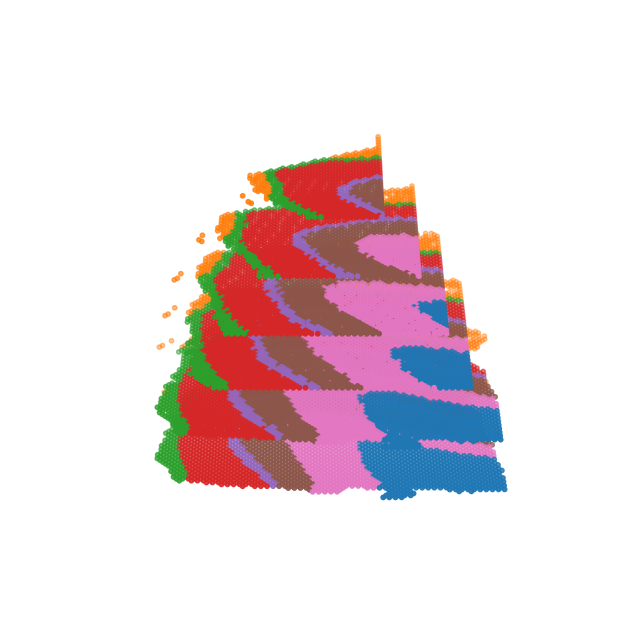

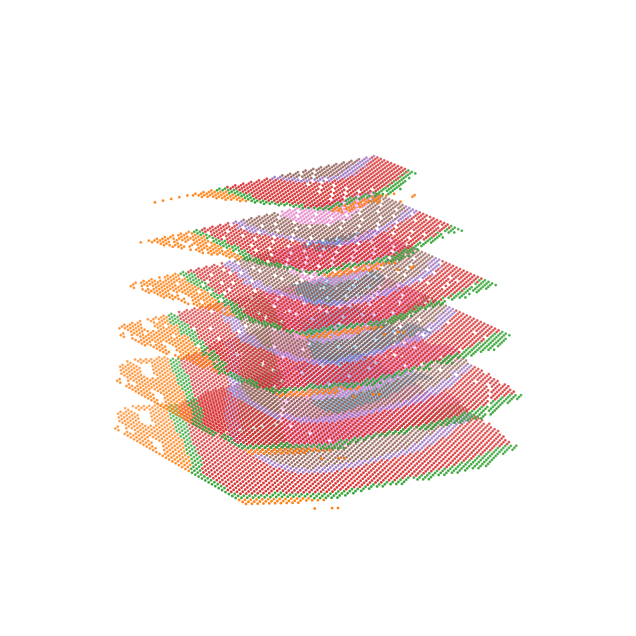

In [66]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from SPACEL import Scube
import os
cmap = []
for e in plt.get_cmap('tab10').colors:
    cmap.append(matplotlib.colors.rgb2hex(e))
coo = pd.DataFrame()
slice_id=[00,100,80,60,40,20]
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/sim_coord.csv',index_col=0)
 
for index, i in enumerate(slice_id):
    embedding=df_1.loc[df_1['slice'] == i,]
    embedding['Z'] = index
    embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip([0,1,2,3,4,5,6],cmap)))
    
    coo = pd.concat([coo,embedding],axis=0)
 
coo = coo[['X', 'Y','Z','original_clusters','celltype_colors','slice']]
coords=coo.values[:,:3]
# Reorder columns
coo['X'], coo['Z'] = coo['Z'], coo['X']
coo['X'], coo['Y'] = coo['Y'], coo['X']
coo['Z'] = -coo['Z']
print(coords)

 
coo.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/Scube_outputs/scHolography_simu_aligned_coordinates_colors.csv')
'''
coords[:,[2, 0]] = coords[:,[0, 2]]
coords[:,[1, 0]] = coords[:,[0, 1]]
coords[:, 2] = -coords[:, 2]
'''
#2. save fig
fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=20, azim=90, frameon=False, show=True, s=10, return_fig=True) # Scube is from SPACEL

fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "scHolography_gtAndScube_simuData_3dviz_angle20_90_1128_24_s=10.pdf"), bbox_inches="tight")

fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=20, azim=-35, frameon=False, show=True, s=1, return_fig=True)

#fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "spacel_gtAndScube_mouse_3dviz_angle20_-35_upsidedown_0719_24.pdf"), bbox_inches="tight")

/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_8445/702023793.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding['Z'] = index
/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_8445/702023793.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip([0,1,2,3,4,5,6],cmap)))
/var/folders/g9/d9lzzvbj58g59v4hfv7m4c4r0000gn/T/ipykernel_8445/702023793.py:16: SettingWithCopyWarning: 
A value is trying to be se

[[10162.0 8505.0 0]
 [4446.0 9571.0 0]
 [9620.0 4192.0 0]
 ...
 [5068.0 9690.5 3]
 [4866.0 7893.5 3]
 [6529.0 3345.5 3]]


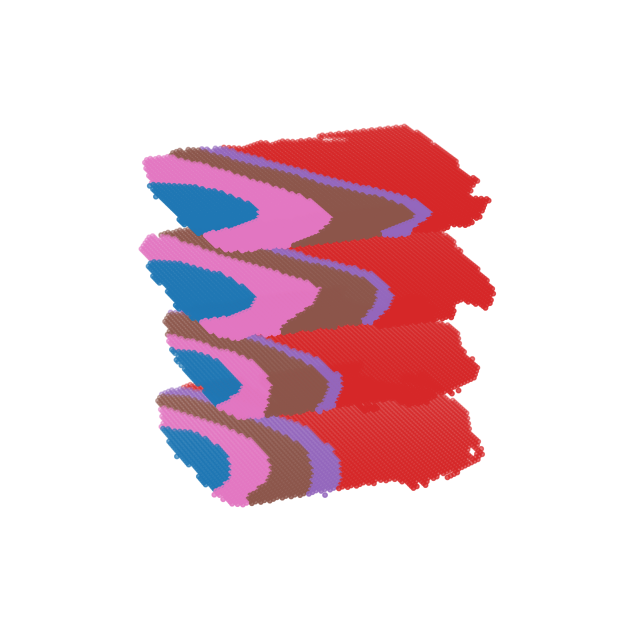

In [57]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from SPACEL import Scube
import os
cmap = []
for e in plt.get_cmap('tab10').colors:
    cmap.append(matplotlib.colors.rgb2hex(e))
coo = pd.DataFrame()
slice_id=['151669','151670', '151671', '151672']
df_1=pd.read_csv('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4/151669_151672_coord.csv',index_col=0)
#slice_id=[100,80,60,40,20]
 
for index, i in enumerate(slice_id):
    embedding=df_1.loc[df_1['slice'] == int(i),]
    embedding['Z'] = index
    embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip([0,1,2,3,4,5,6],cmap)))
    
    coo = pd.concat([coo,embedding],axis=0)
 
coo = coo[['X', 'Y','Z','original_clusters','celltype_colors','slice']]
coords=coo.values[:,:3]
print(coords)
'''
coo['X'], coo['Z'] = coo['Z'], coo['X']
coo['X'], coo['Y'] = coo['Y'], coo['X']
coo['Z'] = -coo['Z']
print(coords)
#coords = coo.values[:,:3]
'''
#coo.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/Scube_outputs/scHolography_DLPFC_151673_151676_aligned_coordinates_colors.csv')
'''
coords[:,[2, 0]] = coords[:,[0, 2]]
coords[:,[1, 0]] = coords[:,[0, 1]]
coords[:, 2] = -coords[:, 2]
'''
#2. save fig
fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=20, azim=160, frameon=False, show=True, s=10, return_fig=True) # Scube is from SPACEL

fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset/alignment/DLPFC4', "scHolography_gtAndScube_DLPFC_151669_151672_3dviz_angle20_160_1122_24.pdf"), bbox_inches="tight")

                         X            Y  Z original_clusters celltype_colors
AAACAAGTATCTCCCA-1  9791.0  8468.000000  0                 3         #d62728
AAACAATCTACTAGCA-1  5769.0  2807.000000  0                 1         #ff7f0e
AAACACCAATAACTGC-1  4068.0  9505.000000  0                 0         #1f77b4
AAACAGAGCGACTCCT-1  9271.0  4151.000000  0                 3         #d62728
AAACAGCTTTCAGAAG-1  3393.0  7583.000000  0                 5         #8c564b
...                    ...          ... ..               ...             ...
TTGCCGGTGATCCCTC-1  5151.0  8843.855937  5                 3         #d62728
TTGCGGCGACTCATGC-1  4055.0  6708.237291  5                 2         #2ca02c
TTGCTGGCCGGGCTTC-1  4260.5  7776.046614  5                 3         #d62728
TTGGATCGACTTCTGG-1  3233.0  7182.819213  5                 3         #d62728
TTGTATCACACAGAAT-1  3781.0  7894.692095  5                 3         #d62728

[14467 rows x 5 columns]


/opt/anaconda3/envs/spacia/lib/python3.8/site-packages/SPACEL/Scube/plot.py:63: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(loc[:,0], loc[:,1], loc[:,2],c=color,*args,**kwargs)


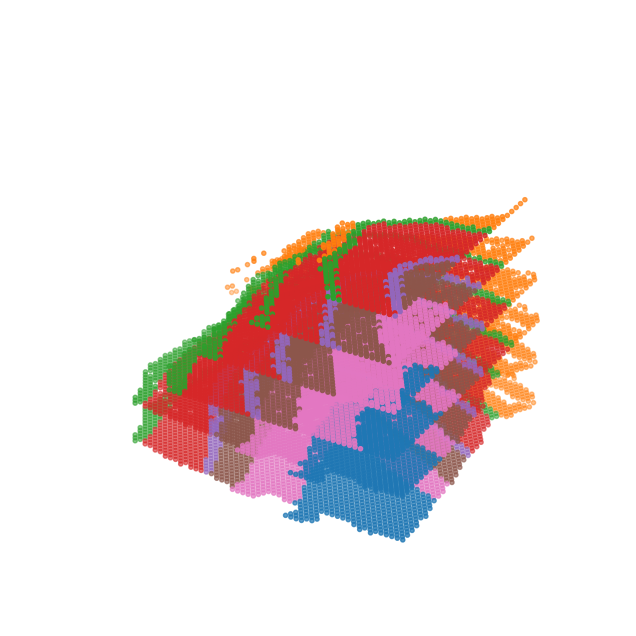

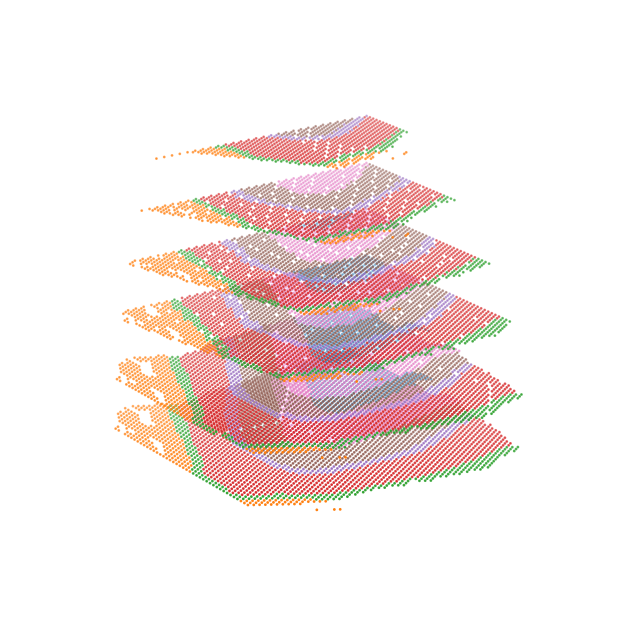

In [142]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from SPACEL import Scube
import os
cmap = []
for e in plt.get_cmap('tab10').colors:
    cmap.append(matplotlib.colors.rgb2hex(e))
coo = pd.DataFrame()
slice_id=[100,80,60,40,20]
adata=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673original_spotIndex.h5'))
embedding = adata.obsm['spatial'].copy()
embedding=pd.DataFrame(embedding).set_index(adata.obs_names)
embedding['Z'] = 0
embedding['original_clusters']=np.array(adata.obs['original_clusters']) 
embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip(['0','1','2','3','4','5','6'],cmap)))
 
embedding = embedding.rename(columns={0: "X",1: "Y"})
coo = pd.concat([coo,embedding],axis=0)

for index, i in enumerate(slice_id):
    adata=sc.read_h5ad(osp.join('/Users/zhuyuling/Desktop/Dataset/simData/DLPFC_151673_overlap='+str(i)+'__pseudocount_0_spotIndex.h5'))
    embedding = adata.obsm['spatial'].copy()
    embedding=pd.DataFrame(embedding).set_index(adata.obs_names)
    embedding['Z'] = index+1
    embedding['original_clusters']=np.array(adata.obs['original_clusters'])
    embedding['celltype_colors'] = embedding['original_clusters'].replace(dict(zip(['0','1','2','3','4','5','6'],cmap)))
    
    embedding = embedding.rename(columns={0: "X",1: "Y"})
    coo = pd.concat([coo,embedding],axis=0)
coords = coo.values[:,:3]
print(coo)
# Reorder columns
coo['X'], coo['Z'] = coo['Z'], coo['X']
coo['X'], coo['Y'] = coo['Y'], coo['X']
coo['Z'] = -coo['Z']
 
#coords = coo.values[:,:3]
 
#coo.to_csv('/Users/zhuyuling/Desktop/Dataset/alignment/Scube_outputs/scHolography_simu_aligned_coordinates_colors.csv')
'''
coords[:,[2, 0]] = coords[:,[0, 2]]
coords[:,[1, 0]] = coords[:,[0, 1]]
coords[:, 2] = -coords[:, 2]
'''
#2. save fig
fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=30, azim=120, frameon=False, show=True, s=9, return_fig=True) # Scube is from SPACEL

#fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "scHolography_gtAndScube_mouse_3dviz_angle30_210_1122_24.pdf"), bbox_inches="tight")

fig = Scube.plot_3d(coords, val=None, color=coo['celltype_colors'], elev=20, azim=-35, frameon=False, show=True, s=1, return_fig=True)

#fig.savefig(os.path.join('/Users/zhuyuling/Desktop/Dataset', "spacel_gtAndScube_mouse_3dviz_angle20_-35_upsidedown_0719_24.pdf"), bbox_inches="tight")